# Getting Started with LSTMs in PyTorch


## Step 1: Setting Up the PyTorch Environment


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch Version: {torch.__version__}")

PyTorch Version: 2.6.0+cu124


## Step 2: Defining an LSTM in PyTorch


In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: int):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # nn.LSTM: The core LSTM layer.
        #   input_size: The number of expected features in the input (x).
        #   hidden_size: The number of features in the hidden state (h).
        #   num_layers: Number of recurrent layers. Stacking LSTMs allows for learning hierarchical representations.
        #   batch_first=True: Makes input and output tensors have batch_size as the first dimension.
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # nn.Linear: A fully connected layer that maps the LSTM's final hidden state
        # to the desired output size (our single predicted value).
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, tuple[torch.Tensor, torch.Tensor]]:
        # Initialize hidden and cell states (h0, c0).
        # These are zero tensors, indicating no prior memory at the start of a new sequence.
        # Shape: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device, dtype=x.dtype)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device, dtype=x.dtype)

        # Pass input and initial states through LSTM
        # lstm_out: Output hidden states for each time step from the LAST layer.
        #           Shape: (batch_size, seq_len, hidden_size)
        # hn: The final hidden state for each layer. Shape: (num_layers, batch_size, hidden_size)
        # cn: The final cell state for each layer. Shape: (num_layers, batch_size, hidden_size)
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))

        # Select the output of the last time step.
        # For sequence-to-one prediction, we care about the state after processing the whole sequence.
        last_time_step_output = lstm_out[:, -1, :]

        # Pass the last time step's output through the fully connected layer
        final_prediction = self.fc(last_time_step_output)

        return final_prediction, lstm_out, (hn, cn)

## Step 3: Preparing Input Data & Visualizing It



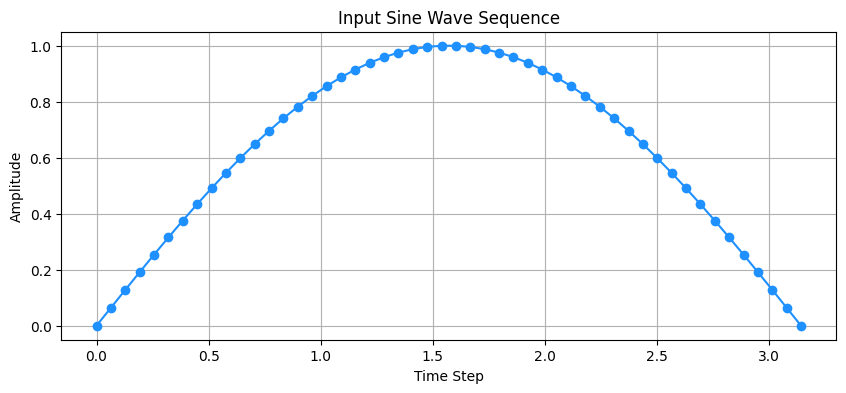

Input Tensor Shape: torch.Size([1, 50, 1])


In [ ]:
# Define data and model parameters
input_dim = 1      # Each data point is a single value (amplitude of sine wave)
hidden_dim = 50    # Increased hidden size for better learning
num_lstm_layers = 2 # Increased layers
output_dim = 1     # We want to predict a single value

seq_len = 50       # Length of the input sequence for training
num_samples = 1000 # Number of sine wave sequences to generate for training

# Sample input data: a sine wave
time_steps = np.linspace(0, np.pi, seq_len, dtype=np.float32)
data = np.sin(time_steps)

# Reshape for LSTM: (batch_size, seq_len, input_size)
# Here, batch_size = 1
input_sequence_reshaped = data.reshape((1, seq_len, input_dim))
input_tensor = torch.tensor(input_sequence_reshaped, dtype=torch.float32)

# Visualizing the input sine wave
plt.figure(figsize=(10, 4))
plt.plot(time_steps, data, marker='o', linestyle='-', color='dodgerblue')
plt.title('Input Sine Wave Sequence')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

print("Input Tensor Shape:", input_tensor.shape)


## Step 4: Instantiating the Model & Processing Data



Training Data Shapes:
  Input Sequences (X_train): torch.Size([1000, 50, 1]) (batch_size, seq_len, input_dim)
  Target Values (y_train): torch.Size([1000, 1]) (batch_size, output_dim)

LSTM Model Architecture:
SimpleLSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

Starting Training...
Epoch [2/20], Loss: 0.4330
Epoch [4/20], Loss: 0.2611
Epoch [6/20], Loss: 0.1248
Epoch [8/20], Loss: 0.0370
Epoch [10/20], Loss: 0.0220
Epoch [12/20], Loss: 0.0263
Epoch [14/20], Loss: 0.0124
Epoch [16/20], Loss: 0.0022
Epoch [18/20], Loss: 0.0062
Epoch [20/20], Loss: 0.0027
Training Complete.


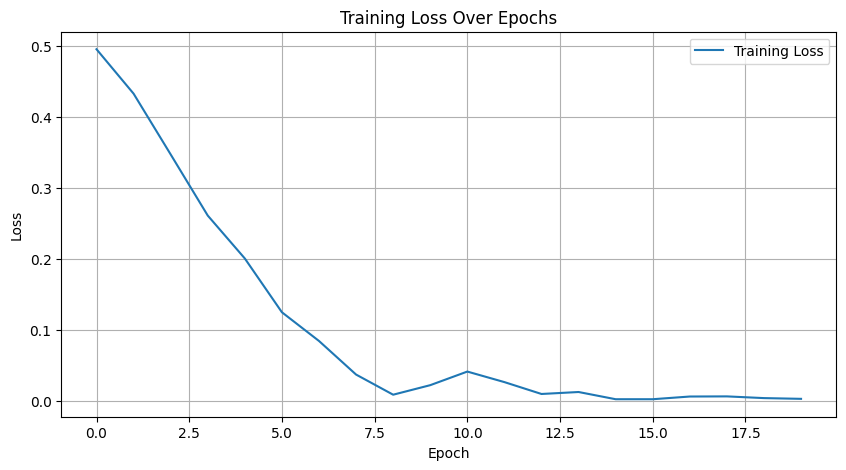

In [ ]:
# --- Data Generation for Training ---
def generate_sine_wave_data(num_samples, seq_len, input_dim):
    X = []
    y = []
    for _ in range(num_samples):
        # Generate a random phase offset for more diverse sine waves
        offset = np.random.rand() * 2 * np.pi
        time_steps = np.linspace(offset, offset + 2 * np.pi, seq_len + 1, dtype=np.float32)
        full_sequence = np.sin(time_steps)

        input_sequence = full_sequence[:-1] # First 'seq_len' points
        target_value = full_sequence[-1]    # The next point

        X.append(input_sequence.reshape(seq_len, input_dim))
        y.append(target_value)
    return np.array(X), np.array(y)

X_train_np, y_train_np = generate_sine_wave_data(num_samples, seq_len, input_dim)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1) # Reshape target for consistency

print(f"\nTraining Data Shapes:")
print(f"  Input Sequences (X_train): {X_train.shape} (batch_size, seq_len, input_dim)")
print(f"  Target Values (y_train): {y_train.shape} (batch_size, output_dim)")

# Instantiate the model
model = SimpleLSTM(input_size=input_dim,
                   hidden_size=hidden_dim,
                   num_layers=num_lstm_layers,
                   output_size=output_dim)

print("\nLSTM Model Architecture:")
print(model)

# --- Training the Model ---
criterion = nn.MSELoss() # Mean Squared Error (MSE) is common for regression tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Adam is a popular and effective optimizer

num_epochs = 20
loss_history = []

print("\nStarting Training...")
for epoch in range(num_epochs):
    model.train() # Set model to training mode (enables dropout, batch norm if present)
    optimizer.zero_grad() # Clear gradients from previous step

    # Forward pass: Get predictions
    predictions, _, _ = model(X_train)
    loss = criterion(predictions, y_train) # Calculate loss

    # Backward pass and optimize: Update model weights
    loss.backward() # Compute gradients
    optimizer.step() # Adjust weights based on gradients

    loss_history.append(loss.item())

    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training Complete.")

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

## Step 5: Evaluation


In [ ]:
# --- Evaluation with a New Sine Wave Sequence ---
# Generate a single new sine wave sequence for demonstration
eval_seq_len = seq_len # Use the same sequence length as training
eval_time_steps = np.linspace(0, np.pi * 2, eval_seq_len + 1, dtype=np.float32)
eval_full_sequence = np.sin(eval_time_steps)
eval_input_sequence = eval_full_sequence[:-1]
eval_true_next_value = eval_full_sequence[-1]

eval_input_tensor = torch.tensor(eval_input_sequence.reshape(1, eval_seq_len, input_dim), dtype=torch.float32)

model.eval() # Set model to evaluation mode (disables dropout, batch norm)
with torch.no_grad(): # Disable gradient calculation for inference (saves memory and speeds up computation)
    final_prediction_eval, all_time_step_outputs_eval, (final_hidden_state_eval, final_cell_state_eval) = model(eval_input_tensor)

print("\n--- Evaluation Output Shapes ---")
print("Shape of Final Prediction (Evaluation):", final_prediction_eval.shape)
print("Shape of All Time Step Outputs (lstm_out from last layer, Evaluation):", all_time_step_outputs_eval.shape)
print("Shape of Final Hidden State (h_n, Evaluation):", final_hidden_state_eval.shape)
print("Shape of Final Cell State (c_n, Evaluation):", final_cell_state_eval.shape)

predicted_value_scalar = final_prediction_eval.detach().numpy()[0, 0]

print(f"\nTrue next value in sequence: {eval_true_next_value:.4f}")
print(f"Model's predicted next value (after training): {predicted_value_scalar:.4f}")


--- Evaluation Output Shapes ---
Shape of Final Prediction (Evaluation): torch.Size([1, 1])
Shape of All Time Step Outputs (lstm_out from last layer, Evaluation): torch.Size([1, 50, 50])
Shape of Final Hidden State (h_n, Evaluation): torch.Size([2, 1, 50])
Shape of Final Cell State (c_n, Evaluation): torch.Size([2, 1, 50])

True next value in sequence: 0.0000
Model's predicted next value (after training): -0.0883


## Step 6: Visualizing Final Prediction in Context


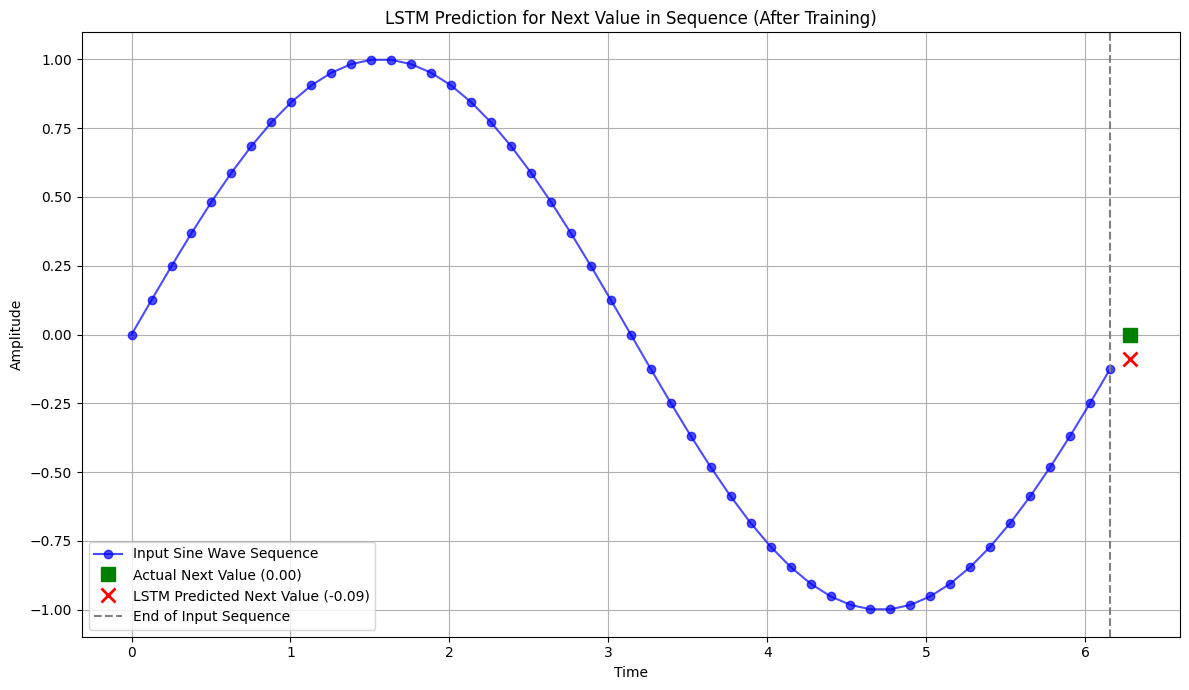

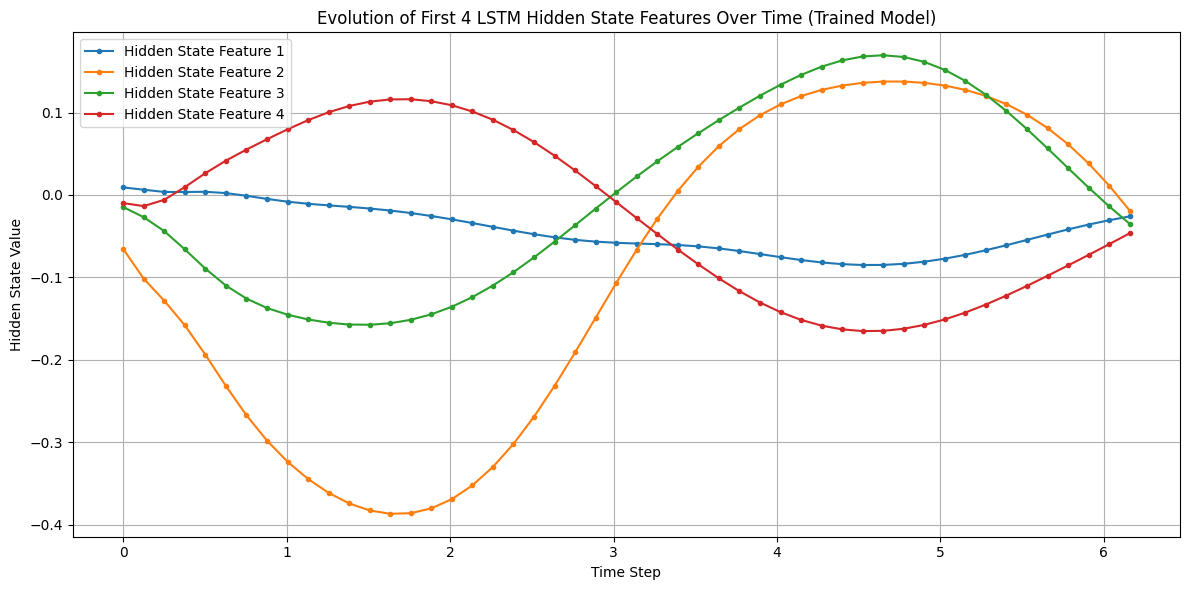

In [ ]:
# --- Visualization of Input, True Next, and Predicted Next ---
plt.figure(figsize=(12, 7))
# Plot the original input sequence
plt.plot(eval_time_steps[:-1], eval_input_sequence, 'bo-', label='Input Sine Wave Sequence', alpha=0.7)

# Plot the true next value
plt.plot(eval_time_steps[-1], eval_true_next_value, 'gs', markersize=10, label=f'Actual Next Value ({eval_true_next_value:.2f})')

# Plot the model's predicted next value
plt.plot(eval_time_steps[-1], predicted_value_scalar, 'rx', markersize=10, markeredgewidth=2, label=f'LSTM Predicted Next Value ({predicted_value_scalar:.2f})')

plt.title('LSTM Prediction for Next Value in Sequence (After Training)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.axvline(eval_time_steps[-2], color='gray', linestyle='--', label='End of Input Sequence') # Adjusted for eval_time_steps
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Visualization of Hidden States from the last LSTM layer over time (after training) ---
# After training, the hidden states should show more meaningful patterns correlated with the input sequence.
hidden_states_over_time_trained = all_time_step_outputs_eval[0].detach().numpy() # Shape: (seq_len, hidden_size)

plt.figure(figsize=(12, 6))
num_features_to_plot = min(hidden_dim, 4) # Plot up to 4 features or hidden_dim if smaller
for i in range(num_features_to_plot):
    plt.plot(eval_time_steps[:-1], hidden_states_over_time_trained[:, i], marker='.', linestyle='-', label=f'Hidden State Feature {i+1}')
plt.title(f'Evolution of First {num_features_to_plot} LSTM Hidden State Features Over Time (Trained Model)')
plt.xlabel('Time Step')
plt.ylabel('Hidden State Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()